<a href="https://colab.research.google.com/github/oconcito8/deepLearning/blob/master/Deep_Learning_Generativo_part04_variational_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ejercicio 1: Entrenar un Variational Autoencoder con la base de dados keras.datasets.fashion_mnist (con las imágenes de Zalando). Una vez que entrenado el modelo, usar la red decoder para convertir vectores espaciales latentes arbitrarios en imágenes. (Mostrar un ejemplo del espacio latente)


In [2]:
from tensorflow.keras.datasets import fashion_mnist
(x_train, _), (x_test, _) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


**Red encoder VAE**

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

# Dimensionalidad del espacio latente: un plano 2D
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
# La imagen de entrada termina siendo codificada
# en estos dos parámetros: z_mean y z_log_var
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [4]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

El siguiente código es para **generar un punto espacial latente ``z``** usando ``z_mean`` y ``z_log_var``, los parámetros de la distribución estadística que se supone que produjeron ``input_img``:

**Capa de muestreo-espacio-latente (Latent-space-sampling)**

In [5]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        # Dibuja un lote de vectores normales aleatorios.
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        # Aplicar la fórmula de muestreo VAE
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

El siguiente código es la **implementación del decodificador**. Redimensionamos el vector ``z`` a las dimensiones de una imagen y luego usamos algunas capas de convolución para obtener una salida de imagen final que tiene las mismas dimensiones que la ``input_img`` original.

**Red de decodificadores VAE, asignando puntos de espacio latente a imágenes**

In [6]:
# Entrada a través de la cual alimentaremos con z
latent_inputs = keras.Input(shape=(latent_dim,))
# Producimos la misma cantidad de coeficientes que
# teníamos al nivel de la capa Flatten en el codificador.
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# Revertimos la capa Flatten del codificador.
x = layers.Reshape((7, 7, 64))(x)
# Revertimos las capas Conv2D del codificador.
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# La salida termina con la forma (28, 28, 1)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [7]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

Creamos el **propio modelo VAE**. **Este es nuestro primer ejemplo de un modelo que no realiza aprendizaje supervisado** (un autoencoder es un ejemplo de **aprendizaje autosupervisado**, porque **utiliza sus entradas como objetivos**). Cada vez que se sale del aprendizaje supervisado clásico, es **común crear una subclase de la clase ``Model`` e implementar un ``train_ step()`` personalizado para especificar la nueva lógica de entrenamiento**.

**Modelo VAE con `train_step()` personalizado**

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        # Usamos estas métricas para realizar un seguimiento
        # de los promedios de pérdida en cada época.
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    # Listamos las métricas en la propiedad metrics para permitir
    # que el modelo las restablezca después de cada época (o entre
    # varias llamadas a fit()/evaluate())
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            # Sumamos la pérdida de reconstrucción sobre las
            # dimensiones espaciales (ejes 1 y 2) y tomamos
            # su media sobre la dimensión del lote.
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # Agreguamos el término de regularización
            # (divergencia de Kullback-Leibler).
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Ahora **instanciamos y entrenar el modelo en dígitos MNIST**. Debido a que la **pérdida se soluciona en la capa personalizada**, **no especificamos una pérdida externa** en el momento de la compilación (``loss=None``), lo que a su vez significa que **no pasaremos los datos target durante el entrenamiento** (como podemos ver, solo pasamos ``x_train`` al modelo en ``fit()``).

**Entrenando la VAE**

In [9]:
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
# Entrenamos en todos los dígitos MNIST, por lo que
# concatenamos las muestras de entrenamiento y prueba.
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
# Notemos que no pasamos un argumento de pérdida a compile(),
# ya que la pérdida ya es parte de train_step()
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
# Notemos que no pasamos objetivos (targets) en fit(),
# ya que train_step() no espera ninguno
vae.fit(mnist_digits, epochs=30, batch_size=128)

11490434/11490434 [==============================] - 2s 0us/step
Epoch 1/30


547/547 [==============================] - 37s 57ms/step - total_loss: 211.3297 - reconstruction_loss: 209.0723 - kl_loss: 2.2576
Epoch 2/30
547/547 [==============================] - 30s 54ms/step - total_loss: 179.2223 - reconstruction_loss: 176.0054 - kl_loss: 3.2168
Epoch 3/30
547/547 [==============================] - 37s 67ms/step - total_loss: 164.5370 - reconstruction_loss: 160.7402 - kl_loss: 3.7970
Epoch 4/30
547/547 [==============================] - 33s 61ms/step - total_loss: 159.5411 - reconstruction_loss: 155.6646 - kl_loss: 3.8765
Epoch 5/30
547/547 [==============================] - 31s 57ms/step - total_loss: 156.3841 - reconstruction_loss: 152.4854 - kl_loss: 3.8988
Epoch 6/30
547/547 [==============================] - 31s 56ms/step - total_loss: 154.5277 - reconstruction_loss: 150.6208 - kl_loss: 3.9069
Epoch 7/30
547/547 [==============================] - 30s 55ms/step - total_loss: 153.0087 - reconstruction_loss: 149.1185 - kl_loss: 3.8903
Epoch 8/30
547/547 [====

Una vez que se entrena el modelo, podemos **usar la red ``decoder``** para **convertir vectores espaciales latentes arbitrarios en imágenes**.

**Muestreo de una cuadrícula de imágenes del espacio latente 2D**

1/1 [==============================] - 0s 17ms/step


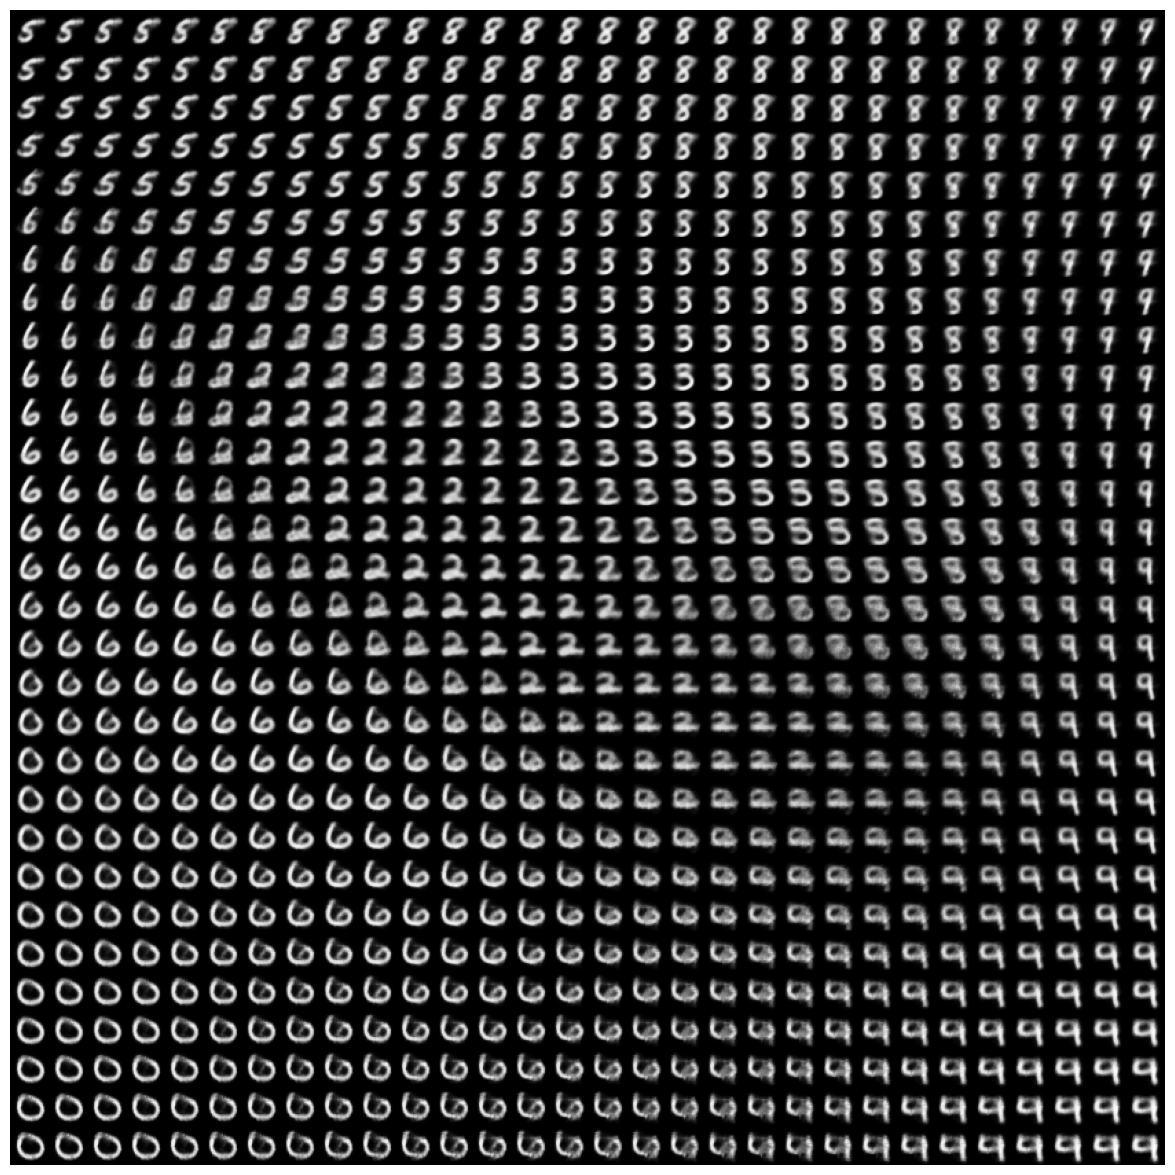

In [10]:
import matplotlib.pyplot as plt

# Mostraremos una cuadrícula de
# 30 × 30 dígitos (900 dígitos en total)
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Muestree de puntos linealmente en una cuadrícula 2D.
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        # Para cada ubicación, muestreamos un
        # dígito y lo agregamos a nuestra figura
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

**Cuadrícula de dígitos decodificados del espacio latente**

La cuadrícula de dígitos muestreados muestra una **distribución completamente continua de las diferentes clases de dígitos**, con **un dígito transformándose en otro** a medida que sigue un camino a través del espacio latente. Las direcciones específicas en este espacio tienen un significado: por ejemplo, hay direcciones para "quinquedad", "unidad", etc.

### Resumiendo

* La **generación de imágenes** con aprendizaje profundo se realiza mediante el **aprendizaje de espacios latentes** que **capturan información estadística sobre un conjunto de datos de imágenes**. Al **muestrear y decodificar puntos del espacio latente, puede generar imágenes nunca antes vistas**. Hay dos herramientas principales para hacer esto: **VAE** y **GAN**.
* Los **VAE** dan como resultado **representaciones latentes continuas y altamente estructuradas**. Por esta razón, funcionan **bien para realizar todo tipo de edición de imágenes en el espacio latente**: intercambio de caras, convertir una cara con el ceño fruncido en una cara sonriente, etc. También funcionan muy **bien para hacer animaciones basadas en el espacio latente**, como mostrar una **imagen inicial que se transforma lentamente en diferentes imágenes de forma continua**.
* Las **GAN permiten la generación de imágenes realistas de un solo cuadro**, pero es posible que **no induzcan espacios latentes con una estructura sólida y una alta continuidad**.